# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

***

In [54]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

df = pd.read_csv('data/human_body_temperature.csv')

In [55]:
# view dataframe
df.head()

,temperature,gender,heart_rate
0,99.3,F,68.0
1,98.4,F,81.0
2,97.8,M,73.0
3,99.2,F,66.0
4,98.0,F,73.0


In [56]:
# basic statistics on dataframe
df.describe()

,temperature,heart_rate
count,130.000000,130.000000
mean,98.249231,73.761538
std,0.733183,7.062077
min,96.300000,57.000000
25%,97.800000,69.000000
50%,98.300000,74.000000
75%,98.700000,79.000000
max,100.800000,89.000000


In [57]:
# dimensionality of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB


### Q1. Is the distribution of body temperatures normal?

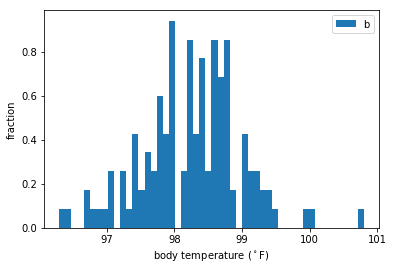

In [58]:
# plot histogram for visual test for normal distribution
_ = plt.hist(df['temperature'],bins=50, density=True)
_ = plt.xlabel('body temperature ($^\circ$F)')
_ = plt.ylabel('fraction')
_ = plt.legend('body temperature', loc='upper right')

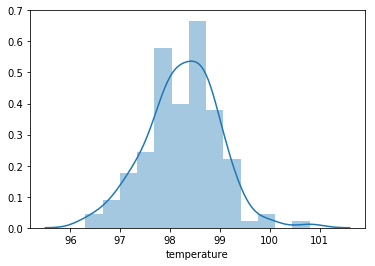

In [59]:
# use seaborn to plot histogram
_ = sns.distplot(df['temperature'])

The histogram of body temperature appears to be normally distributed but we should check with a non-visual approach

In [60]:
# compute t-statistic
mean_temp = np.mean(df['temperature'])
std_temp = np.std(df['temperature'])
t_left = mean_temp - 3*std_temp
t_right = mean_temp + 3*std_temp

# left side
print(sum(df['temperature'] > t_left) / len(df['temperature']))
# right side
print(sum(df['temperature'] < t_right) / len(df['temperature']))

1.0
0.9923076923076923


According to the 68-95-99.7 rule, body temperature is normally distributed.

In [61]:
# conduct normal test
from scipy.stats import normaltest
statistic, p_val = normaltest(df['temperature'])

print('chi-square statistic:', statistic)
print('p value =', p_val)

chi-square statistic: 2.703801433319203
p value = 0.2587479863488254


__A1. The data has a normal distribution. This was verified via both graphical and non-visual tests.__

### 2. Is the sample size large? Are the observations independent?

In [62]:
# test central limit theorem's sample size condition
if len(df) < 30:
    print("The sample size is too small (n < 30)")
else:
    print("The sample size is large (n > 30)")

The sample size is large (n > 30)


M    65
F    65
Name: gender, dtype: int64

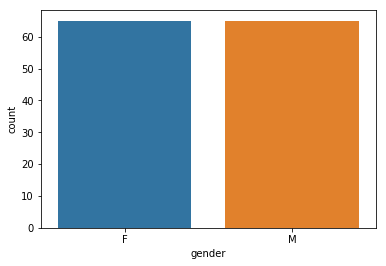

In [63]:
# compute breakdown of 'gender' column to determine independence of observations
sns.countplot(df['gender'])
df['gender'].value_counts()

__A2. The sample size is large enough (n > 30) and the data appears to contain indenpendent observations.__

### Q3. Is the true population mean really 98.6 degrees F

Is it appropriate to use the t or z statistic?
- In this case, the z statistic is more appropriate since the sample size is large (n > 30).

In [78]:
# Bootstrap hypothesis test
# Conduct one-sample z-test (comparing one type of samples, temperature, to the single population mean)
from statsmodels.stats.weightstats import ztest
z_stat, pval_z = ztest(x1 = df['temperature'], value = 98.6)

print("z statistic: ", z_stat)
print("p value = ", pval_z)

z statistic:  -5.4548232923645195
p value =  4.9021570141012155e-08


In [79]:
# Now try using the other test. How is the result different? Why?
from scipy.stats import ttest_1samp
t_stat, p_val_t = ttest_1samp(df['temperature'], 98.6)

print("t-statistic: ", t_stat)
print("p value = ", p_val_t)

t-statistic:  -5.4548232923645195
p value =  2.4106320415561276e-07


The z-statistic and the t-statistic is the same but the p values are different. The p value for the t-statistic is larger than that of the z-statistic.

In [80]:
# Conduct hypothesis test
alpha = 0.05
if p_val_z < alpha: 
    print("The null hypothesis (the true population mean is 98.6 degrees F) can be rejected")
else:
    print("The null hypothesis (the true population mean is 98.6 degrees F) cannot be rejected")

The null hypothesis (the true population mean is 98.6 degrees F) can be rejected


__A3. The true population mean of the body temperature does not appear to be the same as the conventional mean of 98.6 degrees F (p-value < 0.05).__

### Q4. Draw a small sample size 10 from the data and repeat both frequentist tests.
- Which one is the correct one to use?
- What do you notice? What does this tell you about the difference in application of the t and z statistic?

In [81]:
# Generate random sample
np.random.seed(42)
sample = np.random.choice(df['temperature'], size=10)
print(sample)

[98.  98.8 97.8 97.  97.7 98.3 98.  97.9 99.  98. ]


In [82]:
# Conduct one-sample t-test
t_stat, p_val_t = ttest_1samp(sample, 98.6)

print("t-statistic: ", t_stat)
print("p value = ", p_val_t)

t-statistic:  -3.0934479202257976
p value =  0.012857704604809363


In [83]:
# Conduct one-sample z-test
z_stat, p_val_z = ztest(x1 = sample, value = 98.6)

print("z-statistic: ", z_stat)
print("p value = ", p_val_z)

z-statistic:  -3.0934479202257976
p value =  0.0019784527476214603


__A4-1. The t-statistic is appropriate to use in this case since the sample size is small (n < 30).__

__A4-2. The p value is less than 0.05 for the z-test whereas the opposite is true for the t-test. Relying on the t-test, the null hypothesis can be rejected and the true population temperature mean is the same as the sample mean.__

### Q5. At what temperature should we consider someone's temperature to be "abnormal"?
- Try cacluating everything using the bootstrap approach, as well as the frequentist approach.
- Start by computing the margin of error and confidence interval. Keep in mind that you should use the appropriate formula for one draw, and not N draws.

In [84]:
# Calculate 95% confidence interval
from scipy import stats
conf_int = stats.norm.interval(alpha = 0.95, loc = np.mean(df['temperature']), scale = np.std(df['temperature']))

print("95% confidence interval: ", conf_int)

95% confidence interval:  (96.81775582674824, 99.68070571171332)


__A5. Body temperature below 96.8 degrees F and above 99.7 degrees F can be considered "abnormal"__

### Q6. Is there a significant difference between males and females in normal temperature?
- What testing approach did you use and why?
- Write a story with your conclusion in the context of the original problem.

In [99]:
# Separate body temperatures of males and females
m_temps = df[df['gender'] == 'M'].temperature
f_temps = df[df['gender'] == 'F'].temperature

In [100]:
# Conduct two-sample t-test (comparing difference between two quantities / large sample size (n > 30)
from scipy.stats import ttest_ind
t_stat, p_val_t = ttest_ind(m_temps, f_temps)

print("t-statistic: ", t_stat)
print("p value = ", p_val_t)

t-statistic:  -2.2854345381656103
p value =  0.02393188312239561


In [101]:
# Conduct hypothesis test
alpha = 0.05

if p_val_t < alpha:
    print("The null hypothesis (no difference in body temp between males and females) can be rejected")
else: 
    print("The null hypothesis (no difference in body temp between males and females) cannot be rejected")

The null hypothesis (no difference in body temp between males and females) can be rejected


__A6. The null hypothesis is rejected (p value < 0.05), hence we can conclude that there is a difference in body temperature between males and females.__

***

### Conclusion
1. Body temperature data has a normal distribution. 
2. The true population mean of body temperature is not equal to the conventional mean of 98.6 degrees F.
3. Body temperature below 96.8 degrees F and above 99.7 degrees F can be considered "abnormal".
4. There is a statistically significant difference between male and female body temperatures.